# Introduction
As a bibliophile and a former English literature student, the use of language has been of keen fascination. Likewise for those in data science and AI, language has of interested, with the field of Natural Language Processing. It can be used for various aspects such as breaking down key test to its main components to understanding the sentiments behind test and groping text based on their related topics. Such developments have facilitated the growth in products such as chat boxes. 

In this project, its fundamentals of extracting key aspects from text and tokenisation will be examined using the library Spacy. 

# Overview 
At the centre of this project is the novel  Northanger Abbey by Jane Austen. It was first published in 1817 ([Sparknotes, 2022](https://www.sparknotes.com/lit/northangerabbey/facts/)) . It is a coming of age tale focusing on Catherine Morland, who is fascinated by gothic novels, and how she navigates her world([Sparknotes, 2022](https://www.sparknotes.com/lit/northangerabbey/summary/)). 

A copywrite free edition of the tale is accessible via Project Gutenberg ([2022](https://www.gutenberg.org/files/121/121-h/121-h.htm)) and consists of 31 chapters. This copy has additional text before and after the tale including notes on the text. As such, these may be dropped from the review. 

In [1]:
# import spacy for NLP
import spacy
nlp = spacy.load("en_core_web_sm")

# import os for loading kaggle dataset 
import os        

# open dataset
with open ("/kaggle/input/northanger-abbey-by-jane-austen/The Project Gutenberg eBook of Northanger Abbey by Jane Austen.txt") as f:
    doc = nlp(f.read())

# crop the doc to exclude unwanted text
main_text = doc[468:-3836]

# seperate main_text by sentences 
doc_sentences = [sen for sen in main_text.sents]


print("That said, this novel has approx.", len(main_text), "words and",len(doc_sentences), "sentences")

That said, this novel has approx. 98737 words and 3542 sentences


In [2]:
print("The first sentence of this novel is as follows: \n\n", doc_sentences[1].text)

The first sentence of this novel is as follows: 

 Her situation in life, the
character of her father and mother, her own person and disposition,
were all equally against her.


# Key features of the text 
The Spacy library is prebuilt to identify key features in the sentence, name entitles. Applying this to the novel reveals the following, identifying aspects such as names, references to numbers and so forth. 

In [3]:
from spacy import displacy

# display name entitles
displacy.render(main_text[3:253], style = "ent", jupyter = True, )

The scope of this can be extended to include references to family as in this context they refer to characters. That said, it should be noted that this feature is applied in this form only to text that has not been categorised in other ways. 

This lead to text as follows: 

In [4]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

# def to find matching text
def find_match (text, pattern, pattern_name):
    matcher.add(pattern_name, pattern)
    found_matches = matcher(text)
    return found_matches

# patterns to find
pattern_1 = [{"LOWER": "son"}]
pattern_2 = [{"LOWER": "sons"}]
pattern_3 = [{"LOWER": "father"}]
pattern_4 = [{"LOWER": "mother"}]
pattern_5 = [{"LOWER": "daughter"}]
pattern_6 = [{"LOWER": "daughters"}]

# find matching words
family  = find_match(doc, [pattern_1,pattern_2, pattern_3, pattern_4, pattern_5, pattern_6], "family" )


# reclassify family to persons 
from spacy.tokens import Span

family_person = []
for match_id, start , end in family: 
    family_person.append(start)

for i in family_person: 
    try:
        new_ent = Span(doc, i, (i+1), "PERSON")
        doc.ents = list(doc.ents)+[new_ent]
    except:
        pass
#note errors occure if a family member is already classed as a specific name entity 

#apply new name entity on main text
main_text = doc[468:-3836]

#display name entities
displacy.render(main_text[3:253] , style = "ent", jupyter = True, )

# remove family from find
matcher.remove("family")

# Tokenisation
An additional feature of Spacy is to tokenise, categorise, words in a text. When applied to the second sentence of the novel this leads to the following chapter markers can be removed as follows.

In [5]:
# tokenise objects in the second sentence
for token in doc_sentences[1]:  
    print(f"{token.text:{15}} {token.pos_:{5}} {token.tag_:{5}} {token.dep_:{10}}{token.lemma_:{15}} {spacy.explain(token.tag_)}")

Her             PRON  PRP$  poss      her             pronoun, possessive
situation       NOUN  NN    advcl     situation       noun, singular or mass
in              ADP   IN    prep      in              conjunction, subordinating or preposition
life            NOUN  NN    pobj      life            noun, singular or mass
,               PUNCT ,     punct     ,               punctuation mark, comma
the             DET   DT    det       the             determiner

               SPACE _SP   dep       
               whitespace
character       NOUN  NN    nsubj     character       noun, singular or mass
of              ADP   IN    prep      of              conjunction, subordinating or preposition
her             PRON  PRP$  poss      her             pronoun, possessive
father          NOUN  NN    pobj      father          noun, singular or mass
and             CCONJ CC    cc        and             conjunction, coordinating
mother          NOUN  NN    conj      mother          noun, sing

This can enable the user to assess how various words and grammar structures are used in a text. However as chapter breaks are currently included in this text, it will need to be removed. 
Tokenising the remaining words leads to the following table which consists of 102915 tokens. 

In [6]:
import numpy as np
import pandas as pd

# locate chapter headings
pattern_1 = [{"LOWER": "chapter"}, {"IS_SPACE": True, "OP": "*"}]
chapter = find_match(main_text, [pattern_1], "chapter" )


start = [x[1] for x in chapter]
end = [x[2] for x in chapter]   

drop_words = start+end

# drop chapters (function works as chapter headings are 2 tokens long - ie chapter 1 )
Updated_main_text = [elem for i, elem in enumerate(main_text) if i not in drop_words]

# reset find function 
matcher.remove("chapter")

# create dataframe of tokens for teh whole document 
df = pd.DataFrame(columns = ['text', 'POS', 'Tag']) 

data = pd.DataFrame([])

for token in Updated_main_text:
    data = data.append(pd.DataFrame({'TEXT': token.text, 'POS': token.pos_, 'tag': token.tag_,"DEP": token.dep_, "Lemma": token.lemma_, "EXPLAIN": spacy.explain(token.tag_) }, index=[0]), ignore_index=True)

data.head()

,TEXT,POS,tag,DEP,Lemma,EXPLAIN
0,\n\n\n,SPACE,_SP,dep,\n\n\n,whitespace
1,No,DET,DT,det,no,determiner
2,one,NOUN,NN,nsubj,one,"noun, singular or mass"
3,who,PRON,WP,nsubj,who,"wh-pronoun, personal"
4,had,AUX,VBD,aux,have,"verb, past tense"


# Evaluating Tokens 

There are 98673 tokens. However the table contains some data which can perhaps be dropped for example spaces.

In [7]:
print("Number of Tokens:", data.shape[0])

Number of Tokens: 98673


In [8]:
raw_data = data.copy()
raw_data.head()

,TEXT,POS,tag,DEP,Lemma,EXPLAIN
0,\n\n\n,SPACE,_SP,dep,\n\n\n,whitespace
1,No,DET,DT,det,no,determiner
2,one,NOUN,NN,nsubj,one,"noun, singular or mass"
3,who,PRON,WP,nsubj,who,"wh-pronoun, personal"
4,had,AUX,VBD,aux,have,"verb, past tense"


 The resulting table looks as follow: 

In [9]:
# drop spaces
space = raw_data[raw_data["POS"]=="SPACE"].index

df = raw_data.drop(space)

df.head()

,TEXT,POS,tag,DEP,Lemma,EXPLAIN
1,No,DET,DT,det,no,determiner
2,one,NOUN,NN,nsubj,one,"noun, singular or mass"
3,who,PRON,WP,nsubj,who,"wh-pronoun, personal"
4,had,AUX,VBD,aux,have,"verb, past tense"
5,ever,ADV,RB,advmod,ever,adverb


First aspect that may be examined is the use of punctuations. 
This highlights that the key markers such as comma (",") and full stops (".") appear most frequently. 

However ellipsis are also popular.  It should be noted that the use of such punctuations are reported to  bewilder many people ([University of Sussex, 1997](https://www.sussex.ac.uk/informatics/punctuation/colonandsemi/colon))

In [10]:
# identify POS marked as PUNT
PUNCT = df[df["POS"]=="PUNCT"]

# count values in resulting table
PUNCT[["TEXT","EXPLAIN"]].value_counts().head(10).reset_index(name = "count")

,TEXT,EXPLAIN,count
0,",","punctuation mark, comma",6071
1,.,"punctuation mark, sentence closer",2771
2,;,"punctuation mark, colon or ellipsis",1172
3,“,opening quotation mark,1062
4,”,closing quotation mark,1053
5,!,"punctuation mark, sentence closer",423
6,?,"punctuation mark, sentence closer",383
7,—,"punctuation mark, colon or ellipsis",371
8,-,"punctuation mark, hyphen",237
9,:,"punctuation mark, colon or ellipsis",83


The popular tokens from other categories can be reviewed as follows: 

In [11]:
# exclude PUNT from dataframe
words = df[df["POS"]!="PUNCT"]

# examine tokens with POS as X
words[words["POS"]=="X"].head()

,TEXT,POS,tag,DEP,Lemma,EXPLAIN
3028,’s,X,XX,punct,’s,unknown
5356,_,X,LS,nsubj,_,list item marker
6793,1,X,LS,meta,1,list item marker
7810,etc,X,FW,appos,etc,foreign word
7811,.,X,FW,conj,.,foreign word


In [12]:
# examine tokens with POS as SCONJ
words[words["POS"]=="SCONJ"].head()

,TEXT,POS,tag,DEP,Lemma,EXPLAIN
70,though,SCONJ,IN,mark,though,"conjunction, subordinating or preposition"
90,besides,SCONJ,IN,prep,besides,"conjunction, subordinating or preposition"
143,before,SCONJ,IN,mark,before,"conjunction, subordinating or preposition"
161,as,SCONJ,IN,mark,as,"conjunction, subordinating or preposition"
209,where,SCONJ,WRB,advmod,where,wh-adverb


The remaining tokens consist of  various categories such as numbers, yes/no and determiners. 

In [13]:
# examine tokens with POS as NOUN
words[words["POS"]=="NOUN"].head()

,TEXT,POS,tag,DEP,Lemma,EXPLAIN
2,one,NOUN,NN,nsubj,one,"noun, singular or mass"
11,infancy,NOUN,NN,pobj,infancy,"noun, singular or mass"
21,heroine,NOUN,NN,attr,heroine,"noun, singular or mass"
24,situation,NOUN,NN,advcl,situation,"noun, singular or mass"
26,life,NOUN,NN,pobj,life,"noun, singular or mass"


It should be noted that surrounding text influences the information concerning each token. For example, examining the nouns highlights "one" as a noun. Reviewing the first sentence of the text highlights that the "one" comes from the phrase "no one who.." and therefore is not a numerical figure.  

In [14]:
print(doc_sentences[0].text)






CHAPTER 1


No one who had ever seen Catherine Morland in her infancy would have
supposed her born to be an heroine.


In [15]:

# library for data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns 

# function to create graph 
def Category_group(df,POS_type, title):
    extract = df[df["POS"]== POS_type][["TEXT","EXPLAIN"]].value_counts().head(20).reset_index(name = "count")
    
    plt.figure(figsize = (20,8))
    plt.title(title)
    sns.barplot(y = "TEXT", x = "count", data = extract,palette = "crest_r" )
    sns.despine(top = True, right = True, left = False, bottom = False)
    plt.show()

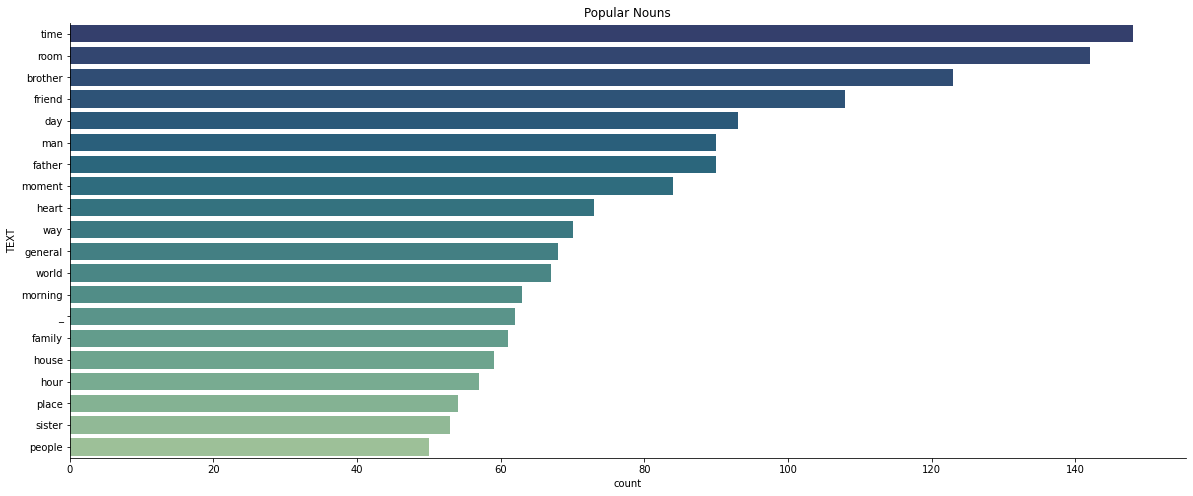

In [16]:
Category_group(words,"NOUN", "Popular Nouns" )

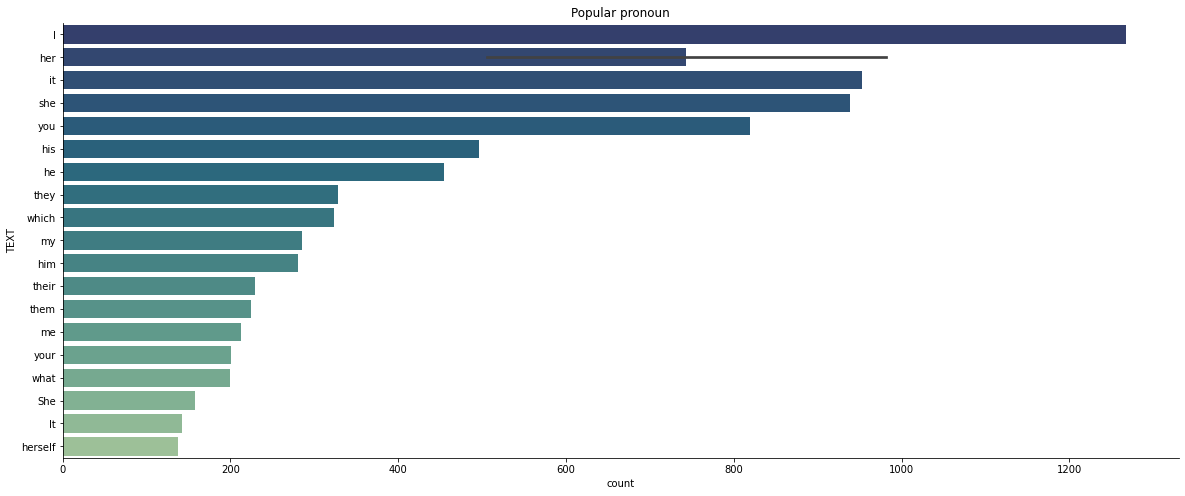

In [17]:
Category_group(words,"PRON", "Popular pronoun" )

The proper noun can indicate some of the most popular characters. That said, if a character is referred to as "she", their reference is broken into the pronoun. As such of this aspect, manual examination will be required. 

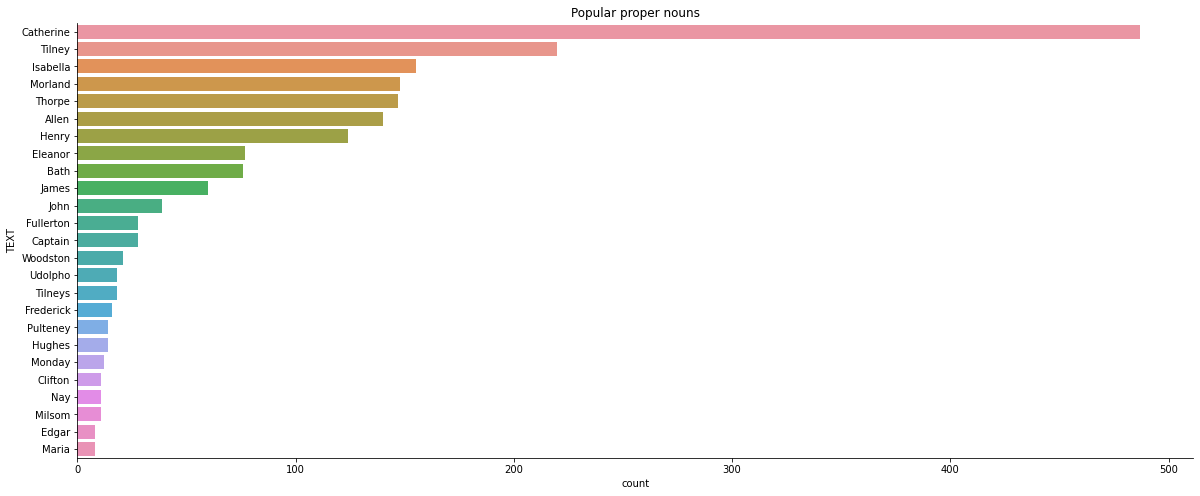

In [18]:
names = words[words["POS"]=="PROPN"][["TEXT","EXPLAIN"]].value_counts().reset_index(name = "count")

#exclude outliers such as Miss and other non-name proper nouns
list = [2,3,4, 335, 20,25, 27, 14,15,18,32,33, 34,36]
name_list = names.drop(list).head(25)


plt.figure(figsize = (20,8))

plt.title("Popular proper nouns")
sns.barplot(y = "TEXT", x = "count", data = name_list)
sns.despine(top = True, right = True, left = False, bottom = False)

# Conclusion
This was a mini-project examining some of the aspects of the spacy library. Whilst this project examines its uses in a playful manner, applying it to a novel, it can have wider users. One key such use is for document checking. For instance, in the aviation items must have a [Certificate of Conformity](http://www.faa-aircraft-certification.com/faa-form-81303-vs-certificate-of-conformity.html). Such documents must be correct and accurate as it travels up the supply chain and therefore frequent checking. Subsequently aspects such as those highlighted here could be used to identify if key aspects have been satisfied. 